&nbsp;

# 4. Optimization 
Optimization is the process of finding the best combination of hyperparameters that minimize your loss function. Optimizing your machine learning algorithms is an important step when making predictions because not every machine learning problem is the same and in comparison, not every solution will be appropriate. Finding the best hyperparameters for your specific solution will ensure that your model will be optimized to your specific problem and will accurately make predictions with a more robust mapping function. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import plot_functions

# Importing chosen models. 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Importing transformers. 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.decomposition import PCA

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train_new_features.csv".format(root)) # Importing the train set.
processed = pd.read_csv(r"{}\train_processed.csv".format(root))
df.set_index("Name", inplace=True)
df.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age Group,Martial Status,Survived
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,S,young adult,Not Married,0
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,female,38.0,1,0,PC 17599,71.2833,C,middle aged,Married,1


&nbsp;

### Section A: Dimensionality Reduction
Principle Component Analysis (PCA) is a feature elimination technqiue used to speed up processing time during training. The main idea is to get rid of similiar features whilst still retaining information of the feature space. Generally, we would want to preserve a an explained variance of between 95-99%. The way PCA works is that it creates a new set of linear features derived from our orginal feature space. 

**A.1: Choosing n_components**<br>
The first step into conducting PCA is to choose the optimal "n_components", which is basically saying how many features would you like PCa to create. We can find the optinal "n_components" by applying the Elbow Method.

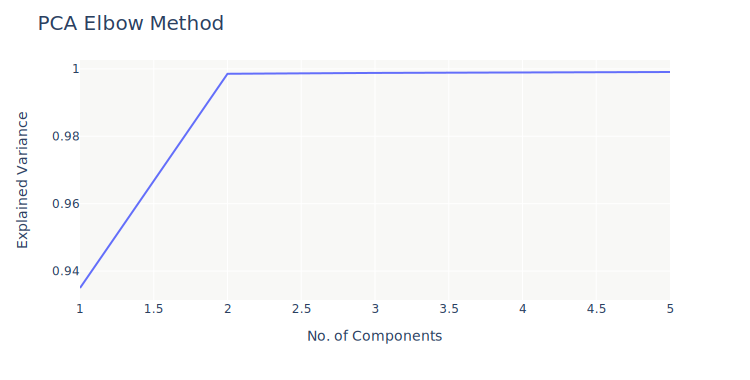

In [3]:
# Splitting the data. 
X = processed.iloc[:,:-1]
y = processed.iloc[:,-1]

# Store variance output. 
explained_variance = list()

# Cycle through explained variance for each no. of features. 
# The reason we use a range of (1, 6) is because the eblow is too difficult to see if we use all 711 features. 
for x in range(1, 6):
    pca = PCA(n_components=x)
    pca.fit(X)    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plotting explained variance against no. of components. 
fig = px.line(x=range(1,6), y=explained_variance)
fig.update_layout(title='PCA Elbow Method',
                       xaxis_title='No. of Components',  
                       yaxis_title='Explained Variance', height=380, width=750, plot_bgcolor='#F8F8F6', title_font_size=20, 
                       title_font_family='Arial Black') 
fig.show()

* What this plot is telling us, is that 2 principle components retains 99.80% of information from the original dataset.
* So, we'll set n_components=2.

In [4]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
LR_pca = functions.model_evaluation()
LR_pca.preprocessing(df)
LR_pca.add_pipe_component("s", StandardScaler())
LR_pca.add_pipe_component("pca", PCA(n_components=2))
LR_pca.add_pipe_component("clf", LogisticRegression(max_iter=1000))
LR_pca.cross_validation(df)

print("Our Logistic Regression Model scored an f1_score of: %.2f%%" % (LR_pca.cv_result))

Our Logistic Regression Model scored an f1_score of: 69.05%


* Hold on a second, why did our f1_score drop by almost 13%?
* It seems even though 2 principle components retains enough information, the performance of the dataset is not favourable. So what we can do is iterate over a range of n_components and use the best score that does not degrade our model performance too harshly.

In [5]:
# Store results from each iteration of n_components. 
pca_resultsLR = dict()
pca_resultsGBC = dict()
pca_resultsXGB = dict()

**A.2: Logistic Regression PCA**<br>
Let's now use our Logistic Regression and iterate over range(1, 50) n_components to find the max f1_score.

In [6]:
functions.optimal_components(LogisticRegression(max_iter=1000), pca_resultsLR, processed) 
new_value = max(pca_resultsLR, key=pca_resultsLR.get)
print("The optimal PCA configuration for Logistic Regression is: n_component=%s, with an f1_score of %.2f%%: " 
      % (new_value, pca_resultsLR[str(new_value)]))

The optimal PCA configuration for Logistic Regression is: n_component=20, with an f1_score of 80.90%: 


**A.3: Gradient Boosting Classifier PCA**<br>
The next step is to do the same process but for our Gradient Boosting Classifier. 

In [7]:
functions.optimal_components(GradientBoostingClassifier(), pca_resultsGBC, processed) 
new_value = max(pca_resultsGBC, key=pca_resultsGBC.get)
print("The optimal PCA configuration for Gradient Boosting Classifier is: n_component=%s, with an f1_score of %.2f%%: " 
      % (new_value, pca_resultsGBC[str(new_value)]))

The optimal PCA configuration for Gradient Boosting Classifier is: n_component=22, with an f1_score of 82.08%: 


**A.4: XGB Classifier PCA**<br>
And now finally we'll iterate up to 50 n_components to find the best f1_score for our XGB Classifier.

In [8]:
functions.optimal_components(XGBClassifier(), pca_resultsXGB, processed) 
new_value = max(pca_resultsXGB, key=pca_resultsXGB.get)
print("The optimal PCA configuration for XGBClassifier is: n_component=%s, with an f1_score of %.2f%%: " 
      % (new_value, pca_resultsXGB[str(new_value)]))

The optimal PCA configuration for XGBClassifier is: n_component=22, with an f1_score of 81.99%: 


| Model | Model Type | n_components | f1_score |
|---------|---------|---------|---------|
| **Logistic Regression** | PCA Logistic Regression | 20 |80.90% |
| **Gradient Boosting Classifier** | PCA Gradient Boosting Classifier | 29 |82.42% |
| **XGB Classifier** | PCA XGB Classifier | 23 |81.28% |

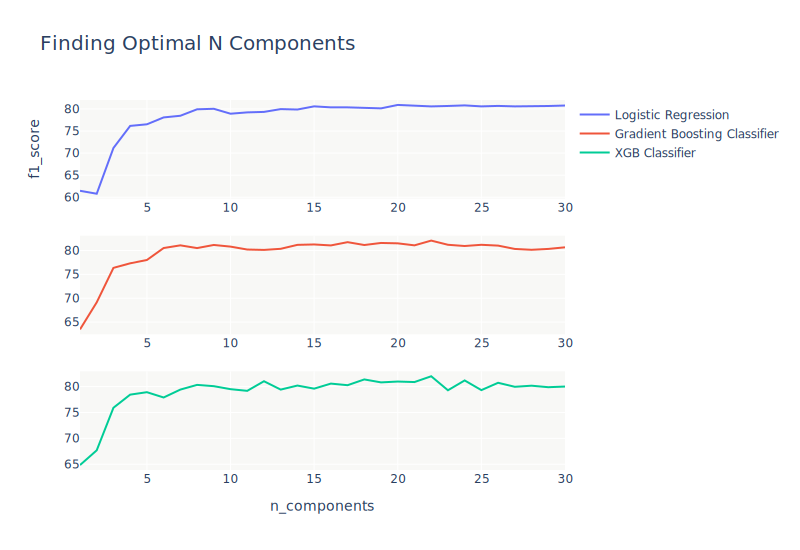

In [9]:
# Setting up axes for each subplot.  
x_axis  = list(range(1,31))
y_axisLR = list(pca_resultsLR.values())
y_axisGBC = list(pca_resultsGBC.values())
y_axisXGB = list(pca_resultsXGB.values())

plot_functions.n_components_plot(xaxis=x_axis, yLR=y_axisLR, yGBC=y_axisGBC, yXGB=y_axisXGB)

* Looking at the plot, we can see that we have consistent performance across all models once n_components > 7.
* f1_score seems to peak once n_components reaches the 20 feature mark.
* We've successfully managed to reduce our feature space from 711 features down to an average of 23. That's a decrease of 96% of the entire dataset with only minimal performance drop, which means processing with GridSearchCV should be alot faster and efficient.

&nbsp;

### Section B: Grid Search Cross Validation
Grid Search Cross Validation is a hyperparameter tuning technique where the user specifies a "parameter grid" (A list of parameters provided with the values they want to test) then evaluates each and every combination using cross validation before outputting the best feature combination for your algorithm. 

**B.1: Logistic Regression Hypertuning**<br>
Unfortunately Logistic Regression does not have many parameters we can hyper tune, so we'll just evaluate a range of C values. 

In [10]:
# Preparing the data. 
pca = PCA(n_components=20)
pcaLR = pca.fit_transform(X)

# Grid search Logistic Regression. 
LR_gs = functions.model_evaluation()
# Adding parameter grid. 
LR_gs.add_params_component('C', [100, 10, 1.0, 0.1, 0.01])
# Evaluate using grid search. 
LR_gs.grid_search(pcaLR, y, LogisticRegression(max_iter=1000))

Best: 0.804310 using {'C': 1.0}


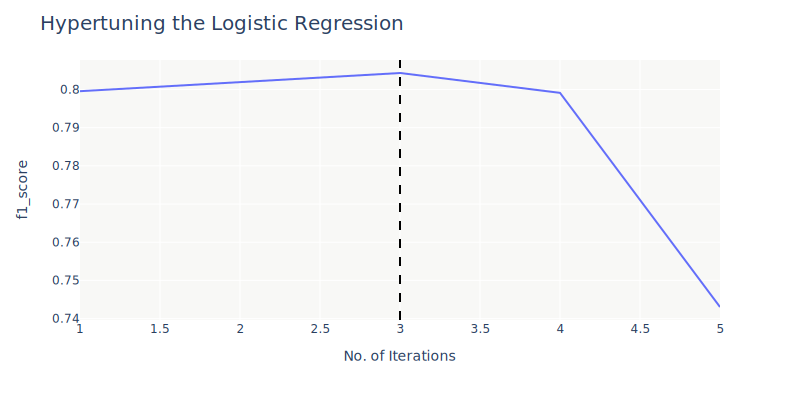

In [11]:
# Plotting results. 
plot_functions.grid_search_plot(LR_gs, "Logistic Regression")

**B.2: Gradient Boosting Classifier Hypertuning**<br>
For our Gradient Boosting Classifier, we'll be hypertuning the tree parameters.

In [12]:
# Preparing the data. 
pca = PCA(n_components=17)
pcaGBC = pca.fit_transform(X)

# Grid search Gradient Boosting Classifier. 
GBC_gs = functions.model_evaluation()
# Adding parameter grid. 
GBC_gs.add_params_component('n_estimators', [50, 250, 500])
GBC_gs.add_params_component('min_samples_split', [2, 30, 50])
GBC_gs.add_params_component('max_depth', [2, 20, 50])
GBC_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
GBC_gs.grid_search(pcaGBC, y, GradientBoostingClassifier())

Best: 0.815212 using {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 250}


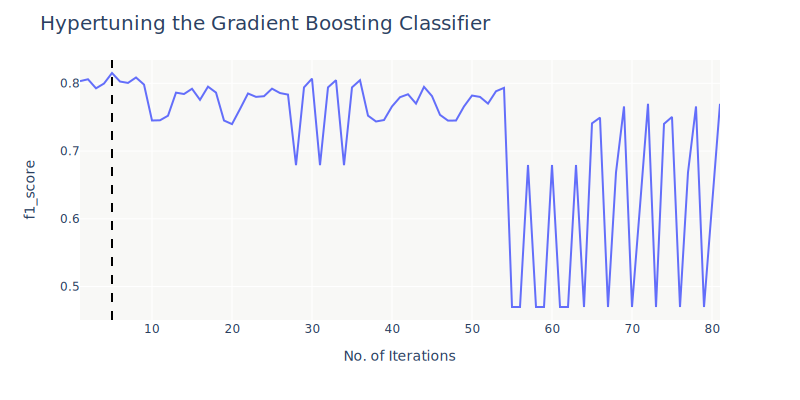

In [13]:
# Plotting results. 
plot_functions.grid_search_plot(GBC_gs, "Gradient Boosting Classifier")

**B.3: XGB Classifier Hypertuning**<br> 
Our XGB Classifier will also be hypertuning the tree parameters.

In [14]:
# Preparing the data. 
pca = PCA(n_components=18)
pcaXGB = pca.fit_transform(X)

# Grid search for XGB Classifier. 
XGB_gs = functions.model_evaluation()
# Adding parameter grid. 
XGB_gs.add_params_component('n_estimators', [50, 250, 500])
XGB_gs.add_params_component('min_child_weight', [1, 5, 15])
XGB_gs.add_params_component('max_depth', [2, 20, 50])
XGB_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
XGB_gs.grid_search(pcaXGB, y, XGBClassifier())

Best: 0.816982 using {'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 250}


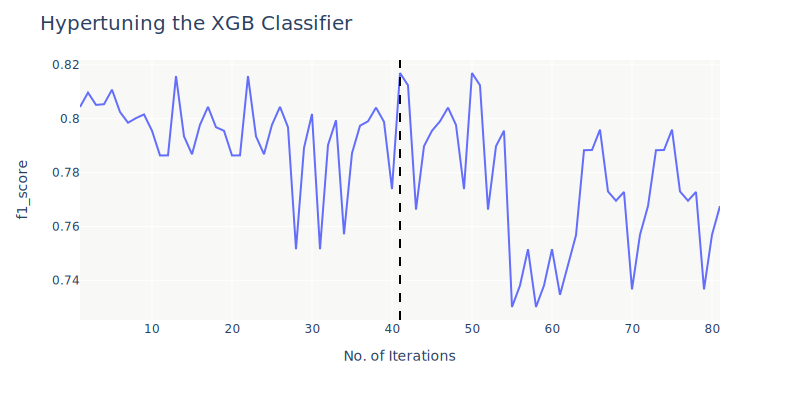

In [15]:
# Plotting results. 
plot_functions.grid_search_plot(XGB_gs, "XGB Classifier")

**B.4: Conclusion**<br>
In conclusion we managed to reduce our feature space by 95% through Principle Component Analysis (PCA) with the only drawback being a minimal hit to our f1_score. This allowed us to hyper tune each classifier algorithm with speed and efficiency as the grid search only had to search through 20+ features as opposed to 700+ in the original dataset.

&nbsp;

| Model | GridSearch CV Score | Final Model | 
|---------|---------|---------|
| **Logistic Regression** |80.04% |LogisticRegression(C=2.0) | 
| **Gradient Boosting Classifier** |81.42% |GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_split=30, n_estimators=250) | 
| **XGB Classifier** |81.19% |XGBRegressor(learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=50) | 

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  